## Импорт библиотек

In [3]:
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

sys.path.append('D:/Programming/Python')

from ml_tools import training_plot

## Загрузка данных

In [4]:
# путь до директории с изображениями
data_path = os.path.abspath("img")
# названия директорий изображений
os.listdir(data_path)

['benign', 'malignant']

In [3]:
# количество чего-либо работающего за раз (за одну итерацию)
batch_size = 32
# размер скейла изображения
img_height, img_width = 224, 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [7]:
import sys

In [8]:
sys.path.append('D:/Programming/Python')

In [9]:
from tools import export2, rounding
from decorators import timeit

"d:\Programming\projects\ML\images\classification\skin_canser/exports/export_file.png" file has created!
"export2" elapsed 3.6788 seconds


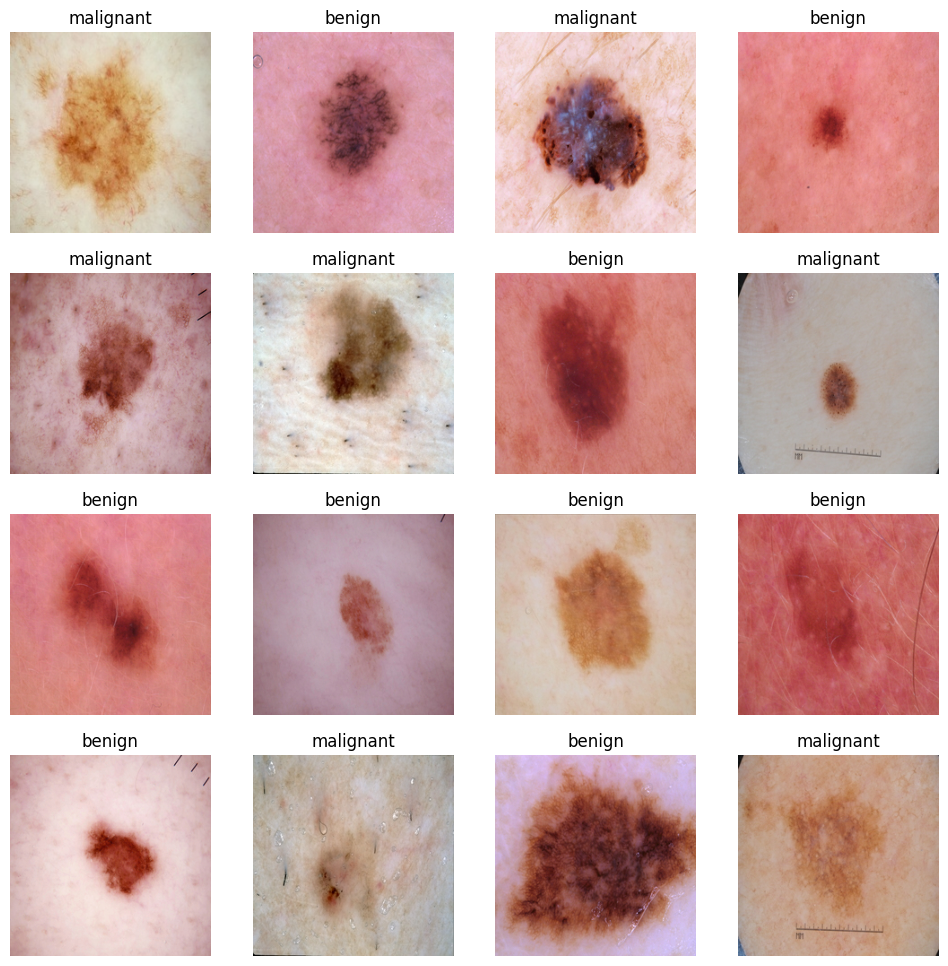

In [10]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
export2(plt, file_extension='png')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Нормализация данных

In [12]:
normalization_layer = layers.Rescaling(1.0/255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0, 1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Python\Python 3.11.6\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)      │        448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)      │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 50176)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │  6,422,656 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,446,498 (24.59 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.5625 - loss: 0.671 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.5234 - loss: 3.557 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.5052 - loss: 4.020 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.5000 - loss: 3.999 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.5000 - loss: 3.859 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.5009 - loss: 3.700 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.5014 - loss: 3.541 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.5017 - loss: 3.394 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.5019 - loss: 3.258 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.5017 - loss: 3.136 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.5031 - loss: 3.024 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.5048 - loss: 2.922 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.5074 - loss: 2.829 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.5088 - loss: 2.744 ━━━━━━━━━━━━━━━━━━━

## Анализ результатов обучения

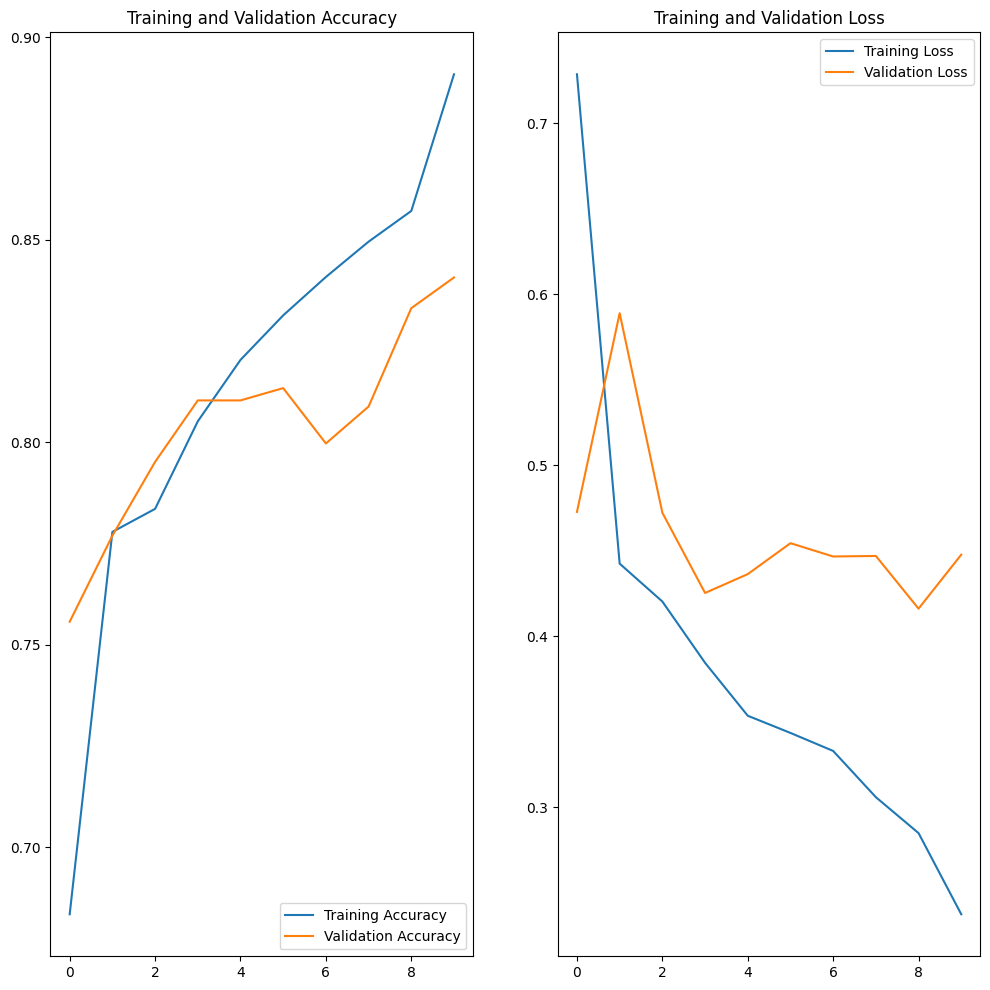

In [18]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

training_analyze(epochs, acc, val_acc, loss, val_loss)

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

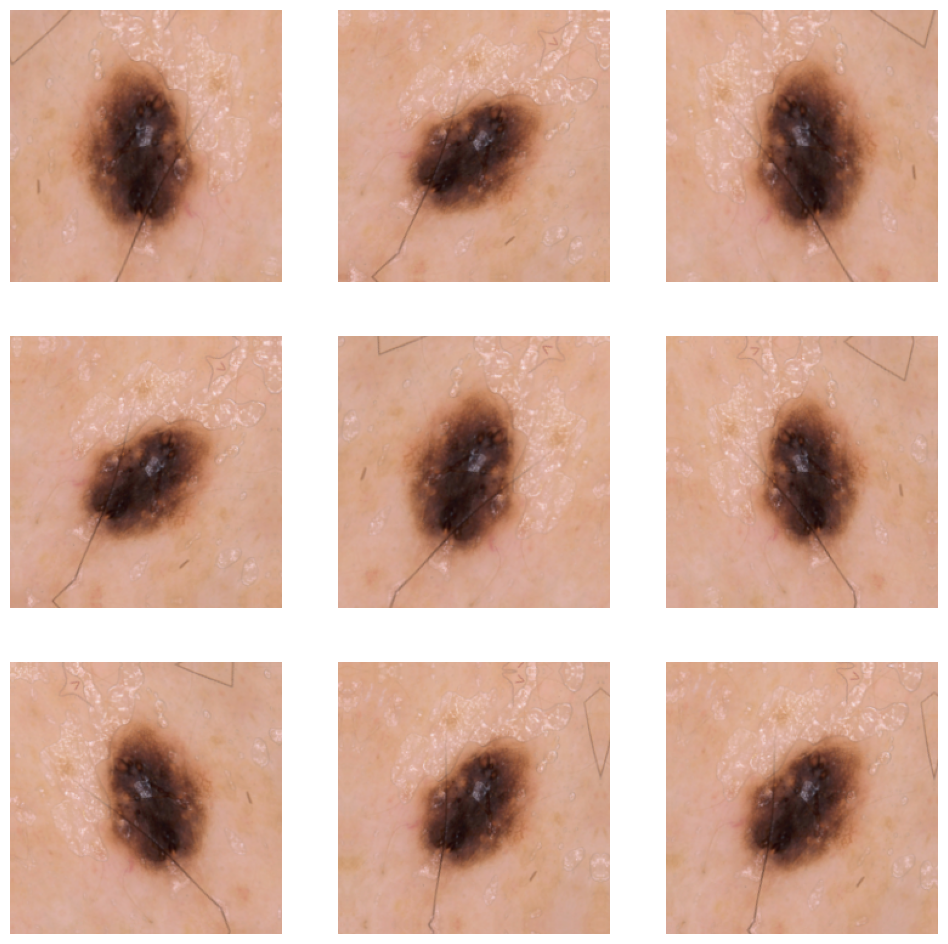

In [20]:
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescaling_2 (Rescaling)         │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.5000 - loss: 0.708 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5391 - loss: 2.525 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5399 - loss: 2.814 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.5241 - loss: 2.892 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5168 - loss: 2.856 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.5148 - loss: 2.777 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.5140 - loss: 2.686 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.5152 - loss: 2.595 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.5162 - loss: 2.509 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.5174 - loss: 2.428 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.5186 - loss: 2.354 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.5199 - loss: 2.286 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.5200 - loss: 2.223 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.5208 - loss: 2.165 ━━━━━━━━━━━━━━━━━━━

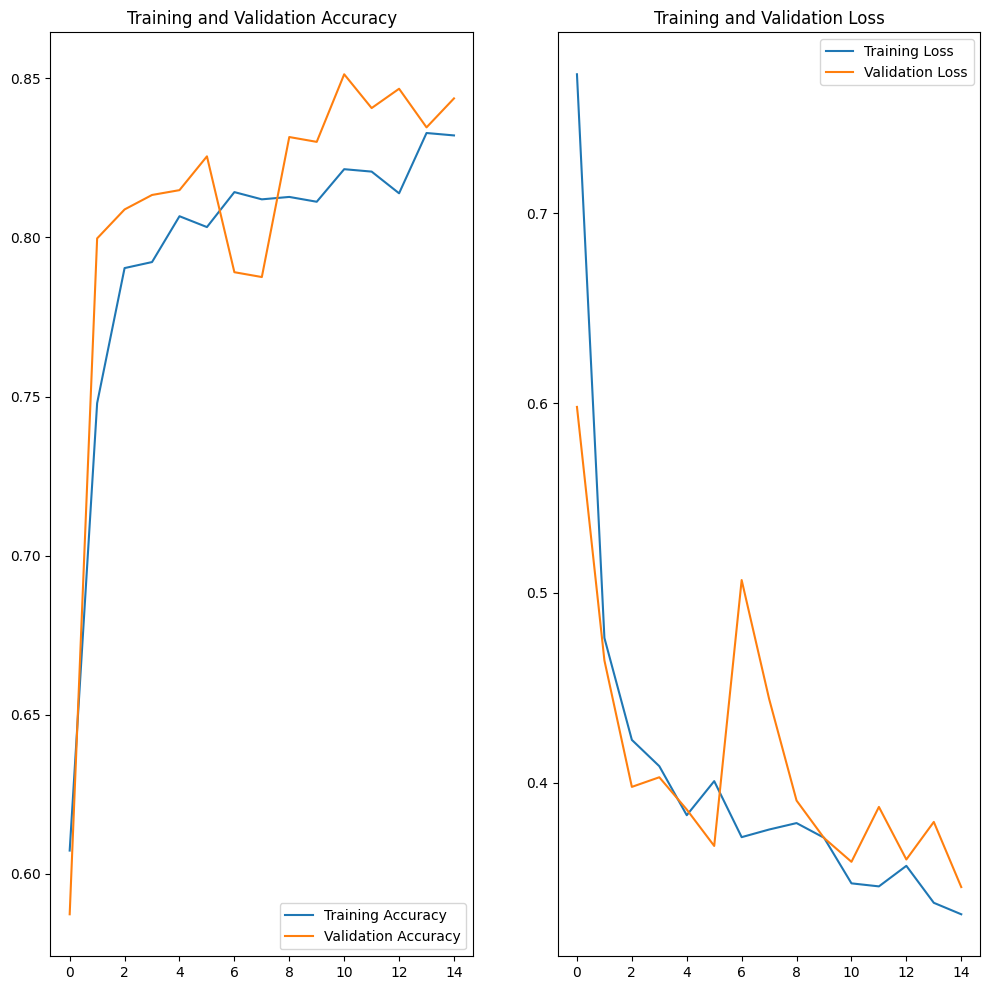

In [25]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

training_analyze(epochs, acc, val_acc, loss, val_loss)

## Экспорт модели

In [26]:
model_name = 'skin_canser'

model_name += '_(' + 'acc' + str(round(acc[-1] * 100, 2)) + '_loss' + str(round(loss[-1] *100, 2)) + ')_'
model_name += '.keras'
if model_name not in os.listdir(): model.save(model_name)

In [27]:
os.listdir()

['skin_cancer.ipynb',
 'skin_canser_(acc83.13_loss33.45)_.keras',
 'photo_2024-01-04_13-25-20 (2).jpg',
 'm1.jpg',
 'm3.jpg',
 'm2.jpg',
 'b1.jpg',
 'photo_2024-01-04_13-25-20.jpg',
 'img',
 '.idea',
 '__pycache__',
 'img.zip',
 'skin_canser_(acc83.85_loss34.31)_.keras',
 'exports',
 'skin_canser_(acc83.21_loss33.07)_.keras']

## Импорт модели

In [28]:
os.listdir()

['skin_cancer.ipynb',
 'skin_canser_(acc83.13_loss33.45)_.keras',
 'photo_2024-01-04_13-25-20 (2).jpg',
 'm1.jpg',
 'm3.jpg',
 'm2.jpg',
 'b1.jpg',
 'photo_2024-01-04_13-25-20.jpg',
 'img',
 '.idea',
 '__pycache__',
 'img.zip',
 'skin_canser_(acc83.85_loss34.31)_.keras',
 'exports',
 'skin_canser_(acc83.21_loss33.07)_.keras']

In [29]:
model_name = 'skin_canser_(acc83.13_loss33.45)_.keras'

model = keras.models.load_model(model_name)

## Ручное тестировани

In [30]:
os.listdir()

['skin_cancer.ipynb',
 'skin_canser_(acc83.13_loss33.45)_.keras',
 'photo_2024-01-04_13-25-20 (2).jpg',
 'm1.jpg',
 'm3.jpg',
 'm2.jpg',
 'b1.jpg',
 'photo_2024-01-04_13-25-20.jpg',
 'img',
 '.idea',
 '__pycache__',
 'img.zip',
 'skin_canser_(acc83.85_loss34.31)_.keras',
 'exports',
 'skin_canser_(acc83.21_loss33.07)_.keras']

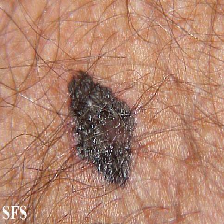

In [31]:
img = tf.keras.utils.load_img(
    'm3.jpg', 
    target_size=(img_height, img_width))
img

In [32]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"Это изображение на {round(np.max(score) * 100, 2)} % похоже на {class_names[np.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Это изображение на 79.15 % похоже на malignant
